In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from scipy.signal import medfilt
import os, time

os.environ["CRDS_PATH"] = "/home/lee/data_archive/crds_cache/jwst_ops"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [2]:
import jwst
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.linearity import LinearityStep
from jwst.dark_current import DarkCurrentStep
from jwst.datamodels import dqflags, CubeModel
                                                                                 

os.environ["CRDS_PATH"] = "/home/lee/data_archive/crds_cache/jwst_ops"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print('JWST pipeline version: ', jwst.__version__)

JWST pipeline version:  1.17.1


In [3]:
segment = 1
input_dir = "/home/lee/nat_lab/excite_pipleline/data"
output_dir =  input_dir
uncal_file = "jw01366004001_04101_00001-seg{:03d}_nrs1_uncal.fits".format(segment)
output_file = "jw01366004001_04101_00001-seg{:03d}_nrs1_L1.fits".format(segment)

In [4]:
# DQInitStep from STScI JWST pipeline
start = time.time()
dq_init_step = DQInitStep()
dq_init_step.output_dir = output_dir
dq_init_step.save_results = False
d_out = dq_init_step.run( os.path.expanduser(os.path.join(input_dir, uncal_file)) )
end = time.time()
print("DQInitStep run time: {:.2f} s".format(end-start))

2025-01-16 11:28:43,800 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2025-01-16 11:28:43,887 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('/home/lee/nat_lab/excite_pipleline/data/jw01366004001_04101_00001-seg001_nrs1_uncal.fits',).
2025-01-16 11:28:43,888 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/lee/nat_lab/excite_pipleline/data
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2025-01-16 11:28:47,163 - CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/home/lee/anaconda3/envs/jwst/lib/python3.12/site-packages/jwst-1.17.1.dist-info)
2025-01-16 11:28:47,705 - stpipe.DQInitStep - INFO - Using MASK reference file /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_mask_0051.fits
2025-01-16 11:28:48,629 - stpipe.DQInitStep - I

DQInitStep run time: 6.70 s


# Gain and RON
Gain is a conversion from DN to counts for each detector pixel. The readout noise (RON) is the noise per pixel on each non-destructive read (NDR).

Below, I recover the gain and RON calibrations from the archive, reproducing in part the functionality implemented in the standard pipeline RampFitStep. 

2025-01-16 13:04:20,105 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2025-01-16 13:04:20,224 - stpipe - INFO - Extracting gain subarray to match science data
2025-01-16 13:04:20,225 - stpipe - INFO - Extracting readnoise subarray to match science data


RON and GAIN run time: 0.28 s


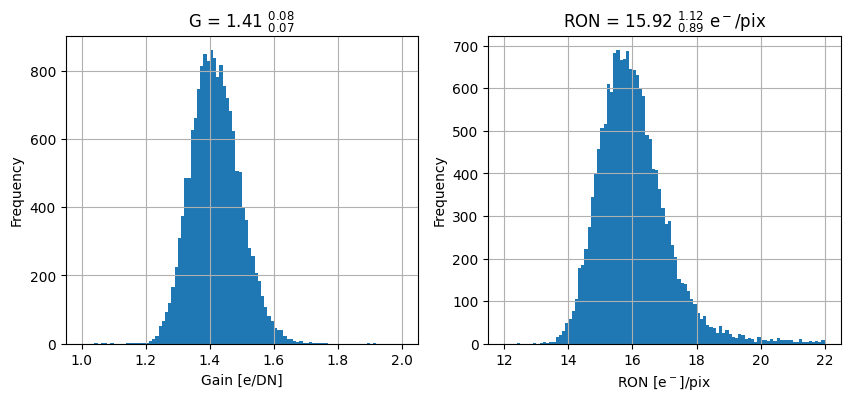

In [13]:
# CustomPipeline
from jwst.ramp_fitting import ramp_fit_step

start = time.time()
st =  ramp_fit_step.RampFitStep()
readnoise_filename = st.get_reference_file(d_out, 'readnoise')
gain_filename = st.get_reference_file(d_out, 'gain')
frames_per_group = d_out.meta.exposure.nframes

readnoise_model = jwst.datamodels.ReadnoiseModel(readnoise_filename)
gain_model = jwst.datamodels.GainModel(gain_filename)

readnoise_2d, gain_2d = ramp_fit_step.get_reference_file_subarrays(
    d_out, 
    readnoise_model, 
    gain_model, 
    frames_per_group)

# convert radnoise_2d from DN to electrons
readnoise_2d *= gain_2d

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))

_=ax0.hist(gain_2d.flatten(), bins=100, range=[1,2] )
_=ax1.hist(readnoise_2d.flatten(), bins=100, range=[12, 22] )

gn = np.percentile(gain_2d, [15.9, 50, 84.1])
rn = np.percentile(readnoise_2d, [15.9, 50, 84.1])

ax0.set_xlabel('Gain [e/DN]')
ax0.set_ylabel('Frequency')
ax0.set_title("G = {:.2f} $_{{{:.2f}}}^{{{:.2f}}}$".format(gn[1], gn[1]-gn[0], gn[2]-gn[1]))
ax0.grid()
ax1.set_xlabel('RON [e$^-$]/pix');
ax1.set_ylabel('Frequency')
ax1.set_title("RON = {:.2f} $_{{{:.2f}}}^{{{:.2f}}}$ e$^-$/pix".format(rn[1], rn[1]-rn[0], rn[2]-rn[1]))
ax1.grid()

end = time.time()
print("RON and GAIN run time: {:.2f} s".format(end-start))

In [14]:
gain_model.meta.exposure.gain_factor

1.429

In [15]:
int_times = d_out.int_times.copy()
DeltaT = (int_times[1][1]-int_times[0][1])*24*3600 # This is the integration time in seconds

print('Integration time {:.3f} s'.format(DeltaT))

Integration time 1.378 s


In [8]:
# SaturationStep from STScI JWST pipeline
d_in = d_out
start = time.time()
saturation_step = SaturationStep()
saturation_step.output_dir = output_dir
saturation_step.save_results = False
d_out = saturation_step.run(d_in)
end = time.time()
print("SaturatonStep run time: {:.2f} s".format(end-start))

2025-01-16 11:33:46,321 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2025-01-16 11:33:46,442 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(6100, 5, 32, 512) from jw01366004001_04101_00001-seg001_nrs1_uncal.fits>,).
2025-01-16 11:33:46,443 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/lee/nat_lab/excite_pipleline/data
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  n_pix_grow_sat: 1
  use_readpatt: True
2025-01-16 11:33:46,459 - CRDS - INFO -  Fetching  /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits    6.4 M bytes  (1 / 1 files) (0 / 6.4 M bytes)
2025-01-16 11:33:47,957 - stpipe.SaturationStep - INFO - Using SATURATION reference file /home/lee/data_archive/crds_cach

SaturatonStep run time: 23.21 s


In [9]:
# SuperBiasStep from STScI JWST pipeline
d_in = d_out
start = time.time()
superbias_step = SuperBiasStep()
superbias_step.output_dir = output_dir
superbias_step.save_results = False
d_out = superbias_step.run(d_in)
end = time.time()
print("SuperBiasStep run time: {:.2f} s".format(end-start))

2025-01-16 11:34:44,854 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2025-01-16 11:34:44,942 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(6100, 5, 32, 512) from jw01366004001_04101_00001-seg001_nrs1_uncal.fits>,).
2025-01-16 11:34:44,943 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/lee/nat_lab/excite_pipleline/data
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2025-01-16 11:34:44,960 - CRDS - INFO -  Fetching  /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_superbias_0299.fits  218.9 K bytes  (1 / 1 files) (0 / 218.9 K bytes)
2025-01-16 11:34:46,414 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_

SuperBiasStep run time: 6.65 s


In [10]:
# LinearityStep from STScI JWST pipeline
d_in = d_out
start = time.time()
linearity_step = LinearityStep()
linearity_step.output_dir = output_dir
linearity_step.save_results = False
d_out = linearity_step.run(d_in)
end = time.time()
print("LinearityStep run time: {:.2f} s".format(end-start))

2025-01-16 12:05:05,972 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2025-01-16 12:05:06,129 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(6100, 5, 32, 512) from jw01366004001_04101_00001-seg001_nrs1_uncal.fits>,).
2025-01-16 12:05:06,130 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/lee/nat_lab/excite_pipleline/data
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2025-01-16 12:05:06,146 - CRDS - INFO -  Fetching  /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits   14.9 M bytes  (1 / 1 files) (0 / 14.9 M bytes)
2025-01-16 12:05:09,015 - stpipe.LinearityStep - INFO - Using Linearity reference file /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_l

LinearityStep run time: 6.38 s


In [11]:
# DarkCurrentStep from STScI JWST pipeline
d_in = d_out
start = time.time()
dark_step = DarkCurrentStep()
dark_step.output_dir = output_dir
dark_step.save_results = False
d_out = dark_step.run(d_in)
end = time.time()
print("DarkCurrentStep run time: {:.2f} s".format(end-start))

2025-01-16 12:05:24,014 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2025-01-16 12:05:24,099 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(6100, 5, 32, 512) from jw01366004001_04101_00001-seg001_nrs1_uncal.fits>,).
2025-01-16 12:05:24,101 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/lee/nat_lab/excite_pipleline/data
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  dark_output: None
  average_dark_current: None
2025-01-16 12:05:24,115 - CRDS - INFO -  Fetching  /home/lee/data_archive/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_dark_0374.fits    4.4 M bytes  (1 / 1 files) (0 / 4.4 M bytes)
2025-01-16 12:05:25,555 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /home/lee/data_archive/crds_c

DarkCurrentStep run time: 5.09 s


# Flag columns as saturated
```
for each group
    select saturated pixel, then
        flag the corresponding columns as saturated, and flag as saturated the adjacent columns as well
```

This selects any pixel saturation transients, flagging to saturated the whole column, including cosmic ray and space ball saturation events.


In [12]:
# CustomPipeline
start = time.time()
idx = np.where(d_out.groupdq & dqflags.pixel['SATURATED'])
for i, j, k in zip(idx[0], idx[1], idx[3]):
    d_out.groupdq[i, j, :, k-1:k+1] |= dqflags.pixel['SATURATED']|dqflags.pixel['DO_NOT_USE']
end = time.time()
print("FlagSatColumns run time: {:.2f} s".format(end-start))

FlagSatColumns run time: 17.15 s


# Estimate CDS
The default CDS is estimated as the difference between the last and first groups in one integration.

All pixels in a column $c$ are set to saturated in a group $g$ if the given column $c$ has at least one pixel flagged as saturated. 

Therefore, the CDS for these columns need to be built from the difference of group $g-1$ and group $0$. If $g=0$, then the CDS cannot be build and is flagged DO_NOT_USE. 

To implement this, I estimate the difference across group flags, and select transients, i.e. select those columns that are set to saturated in $g$, but are not in $g-1$. 

Then I select the frames, groups and colums that are newly saturated, and replace the default CDS with the new one. 

The CDS is normalised to the number of groups (ngroup) used to estimate it. Therefore, it is a **rate**, rather than a classical CDS.

Shot noise variance is 
$$ Var_P = CDS/{\rm ngroup} \propto 1/{\rm ngroup} $$
and the RON variance is
$$ VAR_{RON} = 2\sigma_{RON}^2/{\rm ngroup}^2 \propto 2/{\rm ngroup}^2$$

Therefore in the attributes var_poisson and var_rnoise, it is saved 1/ngroup and 1/ngroup$^2$, respectively.


In [23]:
# CustomPipeline
start = time.time()
d_in = d_out
n0, n1, n2, n3 = d_in.shape
p = np.diff(d_in.groupdq[:,:,n2//2,:] & dqflags.pixel['SATURATED'], axis=1)
idx = np.where(p == dqflags.pixel['SATURATED'])

# Define defaults
cds  = (d_in.data[:, -1, :, :] - d_in.data[:, 0, :, :])/(n1-1)
mask = d_in.groupdq[:, -1, :, :] | d_in.groupdq[:, 0, :, :] | d_in.pixeldq
ngroup = np.zeros_like(cds) + (n1-1)

for i, j, k in zip(*idx):
    # note: j = 0 if saturation occurs in group 1.   CDS cannot be estimated
    #       j = 1 if saturation occurs in group 2.   CDS estimated from groups 1 and 0; ngroup = 1
    #       j = 2 if saturation occurs in group 3.   CDS estimated from groups 2 and 0; ngroup = 2
    #                ...                             ...                                ...
    #                saturation occurs in group j+1. CDS estimated from groups j and 0; ngroup = j
    
    norm = 1 if j == 0 else j
    do_not_use = dqflags.pixel['DO_NOT_USE'] if j == 0 else 0
    #do_not_use = dqflags.pixel['DO_NOT_USE'] 
    cds[i, :, k]    = (d_out.data[i, j, :, k] - d_out.data[i, 0, :, k])/norm
    mask[i, :, k]   = d_in.groupdq[i, j, :, k] | d_in.groupdq[i, 0, :, k] | \
                      d_in.pixeldq[:, k] | do_not_use
    ngroup[i, :, k] = np.nan if j == 0 else j


cds  = np.ma.array(data= gain_2d*cds, mask=mask > 0)
varP = cds/ngroup
varR = np.ma.array(data=2*readnoise_2d**2/ngroup**2, mask=mask > 0)

# Build the cube model
d_out = CubeModel(data        = cds, 
                  dq          = mask,
                  var_poisson = varP,
                  var_rnoise  = varR,
                  int_times   = int_times
                 )


del cds, ngroup, mask, varP, varR, int_times

end = time.time()
print("BuildCDS run time: {:.2f} s".format(end-start))

BuildCDS run time: 10.60 s


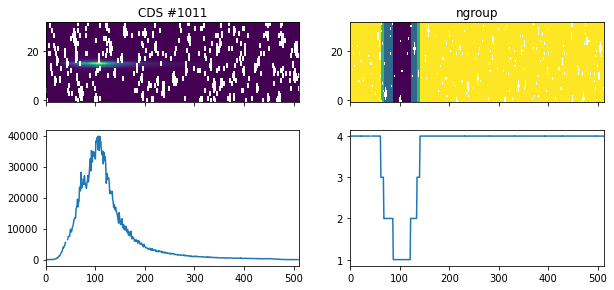

In [24]:
# Diagnostic plots of one selected integration, ngroup, and cross sections
NINT = 1011
fig, ax = plt.subplots(2,2, figsize=(10,5), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0,0].imshow(d_out.data[NINT], aspect=5, origin='lower')
ax[0,0].set_title('CDS #{:d}'.format(NINT))
ax[1,0].plot(d_out.data[NINT, 15])
ax[0,1].imshow(d_out.data[NINT]/d_out.var_poisson[NINT], aspect=5, interpolation='none', origin='lower' )
ax[0,1].set_title('ngroup')
ax[1,1].plot(d_out.data[NINT, 15]/d_out.var_poisson[NINT, 15])


# Background and 1/f noise correction
The CDS background is corrected column-wise estimating the median over the set of 12 pixels in each colum: the 6 from the top and the 6 from the bottom. 

This also takes care of any eventual backgrounds (although tese are negligible and therefore irrelevant for the Poisson noise estimate).

In the same step, I update the pixel noise estimates:
- shot noise variance: unchanged.
- RON variance: is increaded becasue of the pixel-wise background subtraction

In [25]:
# CustomPipeline
start = time.time()
d_in = d_out
n0, n1, n2 = d_in.shape
background = np.ma.stack( (d_in.data[:,0:6, :], d_in.data[:, -6:, :]), axis=1).reshape(n0, -1, n2)
median = np.ma.median(background, axis = 1)
for k in range(n0):
    d_out.data[k] = d_in.data[k]-median[k]

# Update noise estimates
d_out.var_rnoise  *= 1.0 + 1.0/background.shape[1] # not fully correct as it does not account for flagged pixel and outliers

end = time.time()
print("BackgroundSub run time: {:.2f} s".format(end-start))

BackgroundSub run time: 2.30 s


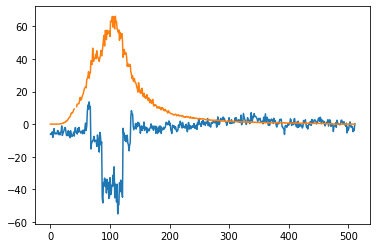

In [26]:
plt.plot(median[200])

plt.plot(d_out.data[200, 15,:]/30000*50)

# Flag outlier
Here we use the sigma_clip Astropy implementation, applied pixel-by-pixel along the temporal axis. This is not fully "correct" because of the transit signal contributing to the RMS. In principle, the transit signal should be removed before applying the the sigma_clip. We will consider a more robust algorithm if needed, later on. 


In [27]:
# CustomPipeline
start = time.time()
d_in = d_out

_cds_ = sigma_clip(d_in.data, sigma=5, axis=0)

new_outliers = (d_in.dq > 0) ^ _cds_.mask 
d_in.dq[new_outliers] |= dqflags.pixel['JUMP_DET'] | dqflags.pixel['DO_NOT_USE']
d_in.data = _cds_

d_out = d_in

end = time.time()
print("sigma_clip run time: {:.2f} s".format(end-start))

sigma_clip run time: 12.17 s


# Time average the pixel timeline
In this way we deal with transients.

In [28]:
# CustomPipeline
start = time.time()

d_in = d_out.copy()
Nave = 25
n0, n1, n2 = d_in.shape

flag = np.ma.array( data = (~d_in.data.mask).astype(np.float32),
                   mask = d_in.data.mask, 
                   fill_value = 0.0)

nave = flag.T.reshape(n2, n1, -1, Nave).sum(axis=-1).T

data = d_in.data.T.reshape(n2, n1, -1, Nave).mean(axis=-1).T
varp = d_in.var_poisson.T.reshape(n2, n1, -1, Nave).mean(axis=-1).T/nave
varr = d_in.var_rnoise.T.reshape(n2, n1, -1, Nave).mean(axis=-1).T/nave
err  = np.sqrt(varp + varr)
dq   = data.mask.astype(np.uint32)

_dtmp_ = CubeModel(data=data.filled(fill_value=0), 
                   dq=dq,
                   var_poisson=varp.filled(fill_value=0),
                   var_rnoise=varr.filled(fill_value=0),
                   err=err.filled(fill_value=0))

print('Sample cadence : {:.2f}'.format(Nave*DeltaT))

end = time.time()
print("TimeAverage: {:.2f} s".format(end-start))


Sample cadence : 34.44
TimeAverage: 3.10 s


In [18]:
_dtmp_.save(os.path.expanduser(os.path.join(output_dir, output_file)))

'/export/sata01/USER_DATA/enzo.pascale/JWST/jwst01366004001/jw01366004001_04101_00001-seg004_nrs1_L1.fits'

In [19]:
d_in = _dtmp_
n1, n2, n3 = _dtmp_.shape
rAper = 7
Nbin = 64
spec_slc = slice(0, -1) # from Rustamkulov '23, Methods 
yc = n2//2 - 1
clc = data[:, yc-rAper:yc+rAper+1, :].reshape(n1, 2*rAper+1,  Nbin, -1).sum(axis=3).sum(axis=1)
var_poisson = varp[:, yc-rAper:yc+rAper+1, :].reshape(n1, 2*rAper+1,  Nbin, -1).sum(axis=3).sum(axis=1)
var_rnoise  = varr[:, yc-rAper:yc+rAper+1, :].reshape(n1, 2*rAper+1,  Nbin, -1).sum(axis=3).sum(axis=1)

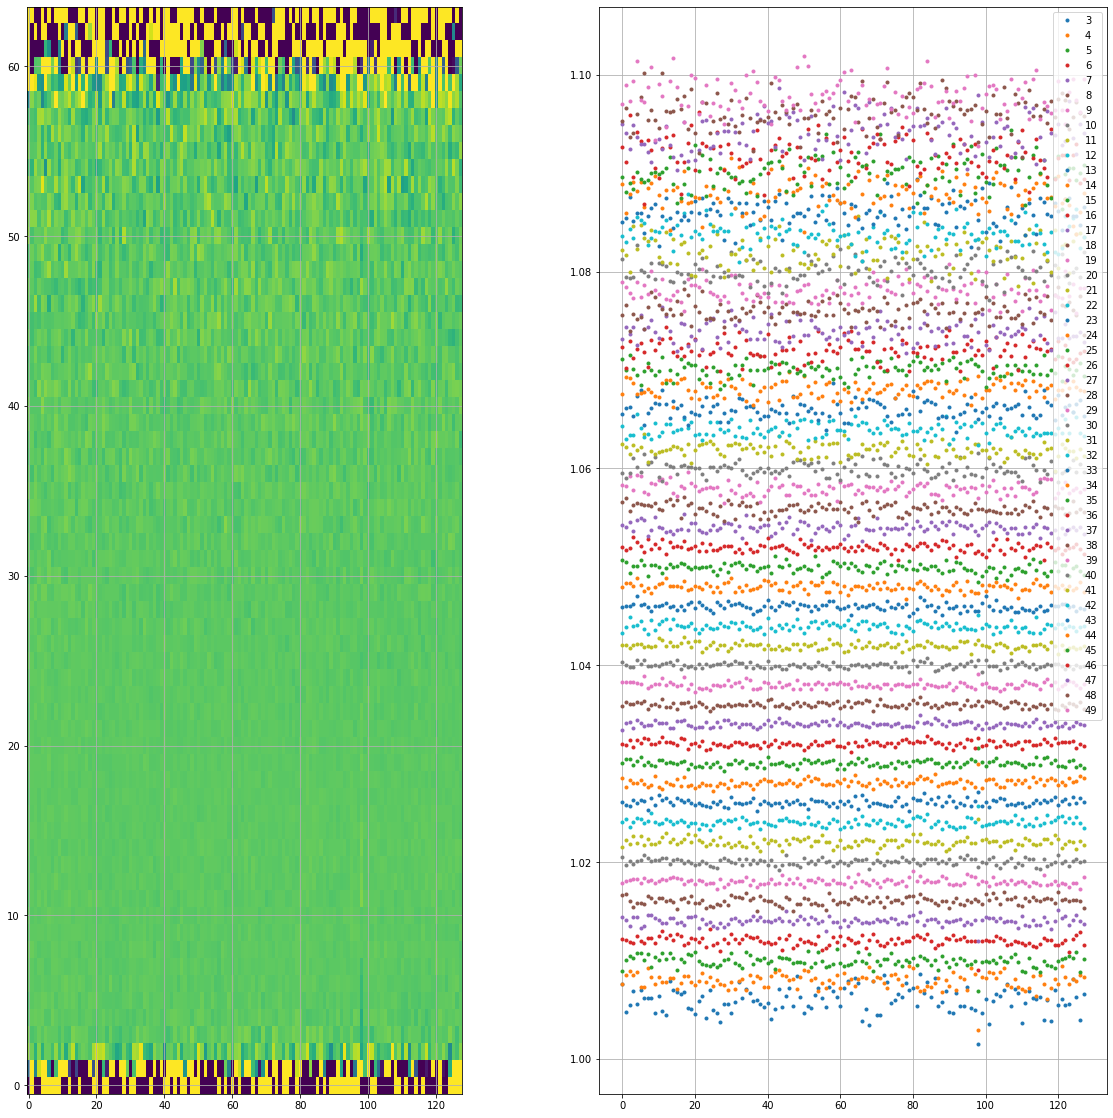

In [20]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,20))
_clc_ = clc/clc[:75].mean(axis=0)
ax0.imshow(_clc_[:,:].T, aspect=5, vmin=0.97, vmax=1.01, interpolation='None', origin='lower')

for k in range(10, _clc_.shape[-1]-10, 8):
    pass #ax1.plot(_clc_[:, k] + (k/800))

#for k in range(10, _clc_.shape[-1]-10, 8):

for k in range(3,50):
    #if k == 7: continue
    ax1.plot(_clc_[:, k]+0.002*k, '.', label=str(k) )

ax1.legend()
ax0.grid()
ax1.grid()
    
    